In [1]:
# Load the numpy libraries
import numpy as np
import tarfile

# load data files

tgzFileName = "ASideFirstModules.tgz"

# Define module training list
moduleFiles = [
    "equalisation_M98_A1",
    "equalisation_M94_A2",
    "equalisation_M96_A3",
    "equalisation_M59_A4",
    "equalisation_N22_A5",
    "equalisation_M116_A6",
    "equalisation_N030_A7",
    "equalisation_M90_A8",
    "equalisation_N029_A9",
    "equalisation_N013_A10"
]

# Define training data set, slot post then ASIC
trainingSet = [
    ("equalisation_N030_A7","VP0-1"), #offset = 2
    ("equalisation_M59_A4","VP0-0"), #offset = 1
    ("equalisation_M98_A1","VP0-1"), #offset = 0
    ("equalisation_N030_A7","VP3-2"), #offset = -1
    ("equalisation_M98_A1","VP2-0") #offset = -2
]

vpList = [ f"VP{i}-{j}" for i in range(4) for j in range(3) ]
evaluationSet = [ (f"{f}", vp) for f in moduleFiles for vp in vpList ]
# want to evaluate all but the training set
evaluationSet = [s for s in evaluationSet if s not in trainingSet]

print(f"Training set: {trainingSet}")
print(f"{len(evaluationSet)} Evaluation sets to test.")
print("first:", evaluationSet[0], "last:", evaluationSet[-1])

def loadTGZ(tgz, fPath, dtype):
    """Load from the tarfile tgz a csv file with a path fPath, shape into 256*256 then cast to dtype"""
    with tgz.extractfile(fPath) as csv:
        return np.genfromtxt(csv,delimiter=",").reshape(256*256).astype(dtype)

def removeMaskNaN(outSet):
    """Remove entries with nan in any file and entries with Mask != 0"""
    aMask = (outSet["mask"] == 0) # start with just mask
    for k in outSet.keys():
        aMask &= ~np.isnan(outSet[k]) # mask out any entry with NaN
    for k in outSet.keys():
        outSet[k] = outSet[k][aMask] # remove masked entries from all arrays
    return outSet

def extractFromTGZ(tgzName, dSet):
    """Open tar.gz file tgzName and find csv files in dSet and return trim files"""
    path = dSet[0]+"/"
    outSet = {}
    with tarfile.open(tgzName,'r:gz') as tgz:
        outSet["tMean0"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_Trim0_Noise_Mean.csv",np.float16)
        outSet["tMeanF"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_TrimF_Noise_Mean.csv",np.float16)
        outSet["tWidth0"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_Trim0_Noise_Width.csv", np.float16)
        outSet["tWidthF"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_TrimF_Noise_Width.csv", np.float16)
        outSet["mask"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_Matrix_Mask.csv", np.float16)
        outSet["trim"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_Matrix_Trim.csv", np.int8)
    return removeMaskNaN(outSet)

def normSet(outSet):
    """Normalize the variables in a consistent way, to compare between sensor"""
    offset = np.mean(outSet["tMean0"]).astype(np.float16)
    outSet["tMean0"] = ( outSet["tMean0"] - offset ) / 75.
    outSet["tMeanF"] = ( outSet["tMeanF"] - (offset+150) ) / 75.
    outSet["tWidth0"] = ( outSet["tWidth0"] - 10 ) / 7.5
    outSet["tWidthF"] = ( outSet["tWidthF"] - 10 ) / 7.5
    return outSet

Training set: [('equalisation_N030_A7', 'VP0-1'), ('equalisation_M59_A4', 'VP0-0'), ('equalisation_M98_A1', 'VP0-1'), ('equalisation_N030_A7', 'VP3-2'), ('equalisation_M98_A1', 'VP2-0')]
115 Evaluation sets to test.
first: ('equalisation_M98_A1', 'VP0-0') last: ('equalisation_N013_A10', 'VP3-2')


In [2]:
from matplotlib import pyplot as plt

# Now plot the data to see what we have as a training set

def plotCorr(ax,trim,val,ytitle):
    xBins = np.arange(-0.5,15.5,1)
    yBins = np.linspace(np.min(val),np.max(val),100)
    ax.hist2d(trim,val,bins=[xBins,yBins])
    ax.set_xlabel('Final Trim')
    ax.set_ylabel(ytitle)

def drawSet(dSet, title='Dataset', norm=False):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(14,3))
    fig.suptitle(title)
    # final Trim
    ax1.hist(dSet["trim"],bins=np.arange(-0.5,15.5))
    ax1.set_xlabel('Final Trim')
    # mean0 & F
    if norm :
        bins = np.linspace(-2,2,128)
    else :
        bins = np.linspace(-0.5,2047.5,128)
    ax2.hist(dSet["tMean0"], bins=bins, label = "0 Mean")
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_xlabel('Mean 0')
    ax3.hist(dSet["tMeanF"], bins=bins, label = "F Mean")
    ax3.legend()
    ax3.set_yscale('log')
    ax3.set_xlabel('Mean F')
    # widths
    if norm :
        bins = np.linspace(-2,2,128)
    else :
        bins = np.linspace(-0.5,25.5, 26)
    ax4.hist(dSet["tWidth0"], bins=bins, label = "0 Width")
    ax4.legend()
    ax4.set_yscale('log')
    ax4.set_xlabel('Width 0')
    ax5.hist(dSet["tWidthF"], bins=bins, label = "F Width")
    ax5.legend()
    ax5.set_yscale('log')
    ax5.set_xlabel('Width F')
    plt.tight_layout()
    plt.show()
    # now correlations
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(12,3))
    plotCorr(ax0,dSet["trim"],dSet["tMean0"],'Mean 0')
    plotCorr(ax1,dSet["trim"],dSet["tMeanF"],'Mean F')
    plotCorr(ax2,dSet["trim"],dSet["tWidth0"],'Width 0')
    plotCorr(ax3,dSet["trim"],dSet["tWidthF"],'Width F')
    plt.tight_layout()
    plt.show()


In [3]:
# Load and plot the training data
trainSets = []
for dSet in trainingSet:
    try:
        outSet = extractFromTGZ(tgzFileName, dSet)
        outSet_norm = normSet(outSet)
        trainSets.append(outSet_norm)
        print("Loaded and normalized training data for:", dSet)
    except Exception as e:
        print("Error loading training data for", dSet, ":", e)

Loaded and normalized training data for: ('equalisation_N030_A7', 'VP0-1')
Loaded and normalized training data for: ('equalisation_M59_A4', 'VP0-0')
Loaded and normalized training data for: ('equalisation_M98_A1', 'VP0-1')
Loaded and normalized training data for: ('equalisation_N030_A7', 'VP3-2')
Loaded and normalized training data for: ('equalisation_M98_A1', 'VP2-0')


In [4]:
def getXYSetFromList(sets):
    X_list = []
    y_list = []
    for dSet in sets:
        print("Unpacking", dSet)
        d = extractFromTGZ(tgzFileName, dSet)
        d = removeMaskNaN(d)
        d = normSet(d)
        X = np.column_stack([d["tMean0"], d["tMeanF"], d["tWidth0"], d["tWidthF"]])
        y = d["trim"]
        X_list.append(X)
        y_list.append(y)
    # Combine all sets along the sample axis
    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)
    return X_all, y_all

# Now, assuming trainingSet is your list/array of 5 training datasets:
X_train, y_train = getXYSetFromList(trainingSet)

# Train your xgboost classifier
import xgboost as xgb
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
print("xgb score on training data =", clf.score(X_train, y_train))


Unpacking ('equalisation_N030_A7', 'VP0-1')
Unpacking ('equalisation_M59_A4', 'VP0-0')
Unpacking ('equalisation_M98_A1', 'VP0-1')
Unpacking ('equalisation_N030_A7', 'VP3-2')
Unpacking ('equalisation_M98_A1', 'VP2-0')
xgb score on training data = 0.841640332136913


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

for s in evaluationSet[:3]:
    print("Using",s,"as evaluation set")
    X_eval, y_eval = getXYSetFromList(s)
    print("xgb score on eval data =",clf.score(X_eval,y_eval))
    y_pred = clf.apply(X_eval)
    # Confusion Matrix and Classification Report
    y_pred_best = np.argmax(y_pred, axis=1)
    print('Confusion Matrix')
    im = plt.imshow(confusion_matrix(y_eval, y_pred_best), norm=LogNorm())
    plt.colorbar(im)
    plt.plot([0,0],[15,15],'r-')
    plt.xlabel("y Prediction")
    plt.ylabel("y True")
    plt.show()
    print('Classification Report')
    print(classification_report(y_eval, y_pred_best))


Using ('equalisation_M98_A1', 'VP0-0') as evaluation set
Unpacking equalisation_M98_A1


KeyError: "filename 'e/Module0_q_Trim0_Noise_Mean.csv' not found"

In [11]:
# =======================
# CELL 2: NEW OPERATIONAL DATA LOADING
# =======================
tgzFileName_new = "Module25_20230621_trim.tgz"

# For the new data, the module prefix is fixed as "Module25".
evaluationSet_new = [("Module25", vp) for vp in vpList]

print(f"\nNew Operational Data:\n {len(evaluationSet_new)} evaluation sets to test.")
print("First:", evaluationSet_new[0], "Last:", evaluationSet_new[-1])

def extractFromTGZ_new(tgzName, dSet) :
    """
    Extract the new operational data files for a given dataset dSet.
    dSet is a tuple: (module_prefix, vp), e.g. ("Module25", "VP0-0").
    For noise files, we skip the header row; for matrix files, we do not.
    """
    module_prefix, vp = dSet
    outSet = {}
    with tarfile.open(tgzName, 'r:gz') as tgz:
        # Noise files (skip header)
        outSet["tMean0"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Trim0_Noise_Mean_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        outSet["tMeanF"] = loadTGZ(tgz, f"{module_prefix}_{vp}_TrimF_Noise_Mean_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        outSet["tWidth0"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Trim0_Noise_Width_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        outSet["tWidthF"] = loadTGZ(tgz, f"{module_prefix}_{vp}_TrimF_Noise_Width_2023-06-21_14-06-30.csv", np.float16, skip_header=True)
        # Matrix files (do not skip header)
        outSet["mask"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Matrix_Mask_2023-06-21_14-06-30.csv", np.float16, skip_header=False)
        outSet["trim"] = loadTGZ(tgz, f"{module_prefix}_{vp}_Matrix_Trim_2023-06-21_14-06-30.csv", np.int8, skip_header=False)
    return removeMaskNaN(outSet)


New Operational Data:
 12 evaluation sets to test.
First: ('Module25', 'VP0-0') Last: ('Module25', 'VP3-2')


VP0-0 : ±1-trim accuracy =  83.1 %
VP0-1 : ±1-trim accuracy =  95.3 %
VP0-2 : ±1-trim accuracy =  64.7 %
VP1-0 : ±1-trim accuracy =  63.2 %
VP1-1 : ±1-trim accuracy =  90.0 %
VP1-2 : ±1-trim accuracy =  92.3 %
VP2-0 : ±1-trim accuracy =  96.3 %
VP2-1 : ±1-trim accuracy =  96.2 %
VP2-2 : ±1-trim accuracy =  81.7 %
VP3-0 : ±1-trim accuracy =  67.5 %
VP3-1 : ±1-trim accuracy =  62.6 %
VP3-2 : ±1-trim accuracy =  83.5 %

Module-25 overall (±1) accuracy :  81.4 ± 12.9  %


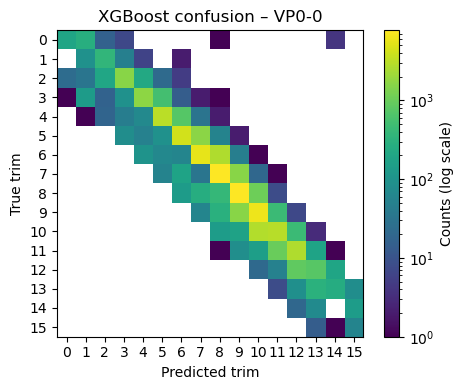

In [ ]:
# ------------------------------------------------------------
#  FULL CELL  – paste & run once
# ------------------------------------------------------------
import numpy as np, tarfile, xgboost as xgb
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt, ticker
from matplotlib.colors import LogNorm

# ---------- universal CSV loader --------------------------------
def loadTGZ(tgz, fPath, dtype, *, skip_header=False):
    """Read CSV 'fPath' inside tarfile 'tgz', reshape to 256×256."""
    with tgz.extractfile(fPath) as fh:
        data = np.genfromtxt(fh, delimiter=",",
                             skip_header=1 if skip_header else 0)
    if data.size != 256*256:
        raise ValueError(f"{fPath}: expected 256×256, got {data.size}")
    return data.reshape(256*256).astype(dtype)

# ---------- generic helpers ------------------------------------
def removeMaskNaN(d):
    keep = (d["mask"] == 0)
    for k in d: keep &= ~np.isnan(d[k])
    return {k: d[k][keep] for k in d}

def normSet(d):
    off = np.mean(d["tMean0"]).astype(np.float16)
    d["tMean0"] = (d["tMean0"] -  off      ) / 75.
    d["tMeanF"] = (d["tMeanF"] - (off+150) ) / 75.
    d["tWidth0"]= (d["tWidth0"]-10) / 7.5
    d["tWidthF"]= (d["tWidthF"]-10) / 7.5
    return d

# ---------- extractors -----------------------------------------
def extractFromTGZ(tgzName, ds):
    path = ds[0] + "/"; vp = ds[1]
    with tarfile.open(tgzName,'r:gz') as tgz:
        out = {
          "tMean0": loadTGZ(tgz,f"{path}Module0_{vp}_Trim0_Noise_Mean.csv",  np.float16),
          "tMeanF": loadTGZ(tgz,f"{path}Module0_{vp}_TrimF_Noise_Mean.csv",  np.float16),
          "tWidth0":loadTGZ(tgz,f"{path}Module0_{vp}_Trim0_Noise_Width.csv", np.float16),
          "tWidthF":loadTGZ(tgz,f"{path}Module0_{vp}_TrimF_Noise_Width.csv", np.float16),
          "mask":   loadTGZ(tgz,f"{path}Module0_{vp}_Matrix_Mask.csv",       np.float16),
          "trim":   loadTGZ(tgz,f"{path}Module0_{vp}_Matrix_Trim.csv",       np.int8)}
    return removeMaskNaN(out)

def extractFromTGZ_new(tgzName, ds):
    mod, vp = ds
    with tarfile.open(tgzName,'r:gz') as tgz:
        out = {
          "tMean0": loadTGZ(tgz, f"{mod}_{vp}_Trim0_Noise_Mean_2023-06-21_14-06-30.csv",
                            np.float16, skip_header=True),
          "tMeanF": loadTGZ(tgz, f"{mod}_{vp}_TrimF_Noise_Mean_2023-06-21_14-06-30.csv",
                            np.float16, skip_header=True),
          "tWidth0":loadTGZ(tgz, f"{mod}_{vp}_Trim0_Noise_Width_2023-06-21_14-06-30.csv",
                            np.float16, skip_header=True),
          "tWidthF":loadTGZ(tgz, f"{mod}_{vp}_TrimF_Noise_Width_2023-06-21_14-06-30.csv",
                            np.float16, skip_header=True),
          "mask":   loadTGZ(tgz, f"{mod}_{vp}_Matrix_Mask_2023-06-21_14-06-30.csv",
                            np.float16),
          "trim":   loadTGZ(tgz, f"{mod}_{vp}_Matrix_Trim_2023-06-21_14-06-30.csv",
                            np.int8)}
    return removeMaskNaN(out)

# ---------- helper to build X, y -------------------------------
def build_Xy(tgzName, sets, extractor):
    X, y = [], []
    for ds in sets:
        d = normSet(extractor(tgzName, ds))
        X.append(np.column_stack([d[k] for k in ("tMean0","tMeanF","tWidth0","tWidthF")]))
        y.append(d["trim"])
    return np.concatenate(X), np.concatenate(y)

# ---------- 1) train on construction tiles ---------------------
tgz_constr = "ASideFirstModules.tgz"
training_tiles = [("equalisation_N030_A7","VP0-1"),
                  ("equalisation_M59_A4","VP0-0"),
                  ("equalisation_M98_A1","VP0-1"),
                  ("equalisation_N030_A7","VP3-2"),
                  ("equalisation_M98_A1","VP2-0")]
X_tr, y_tr = build_Xy(tgz_constr, training_tiles, extractFromTGZ)

clf = xgb.XGBClassifier(n_estimators=200,max_depth=6,
                        learning_rate=0.1,objective='multi:softmax')
clf.fit(X_tr, y_tr)

# ---------- 2) evaluate on Module-25 (2025 data) --------------
tgz_oper = "Module25_20230621_trim.tgz"
vpList   = [f"VP{i}-{j}" for i in range(4) for j in range(3)]
eval25   = [("Module25", vp) for vp in vpList]

acc_tile = []
for ds in eval25:
    X_ev, y_ev = build_Xy(tgz_oper, [ds], extractFromTGZ_new)
    y_hat = clf.predict(X_ev)
    acc_pm1 = (np.abs(y_hat - y_ev) <= 1).mean()*100.0
    acc_tile.append(acc_pm1)
    print(f"{ds[1]} : ±1-trim accuracy = {acc_pm1:5.1f} %")

print(f"\nModule-25 overall (±1) accuracy : "
      f"{np.mean(acc_tile):5.1f} ± {np.std(acc_tile):4.1f}  %")


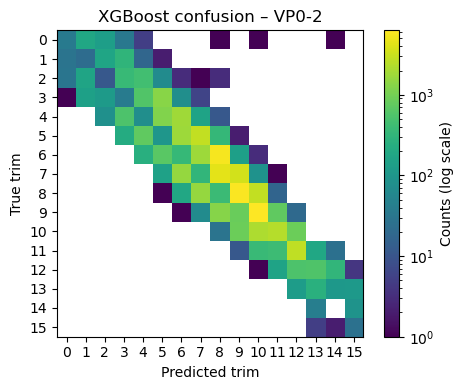

In [16]:
# ---------- 3) confusion plot for one tile ---------------------
tile = ("Module25","VP0-2")      # choose any of the 12 tiles
X_ev, y_ev = build_Xy(tgz_oper,[tile],extractFromTGZ_new)
C = confusion_matrix(y_ev, clf.predict(X_ev), labels=range(16))

plt.figure(figsize=(5,4))
plt.imshow(C, norm=LogNorm(), cmap='viridis')
plt.colorbar(label='Counts (log scale)')
plt.xlabel("Predicted trim"); plt.ylabel("True trim")
plt.xticks(range(16)); plt.yticks(range(16))
plt.title(f"XGBoost confusion – {tile[1]}")
plt.tight_layout(); plt.show()

BDT accuracy on construction set (±1 trim) = 95.76 %


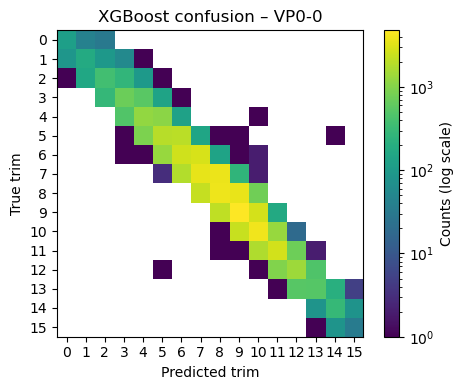

In [15]:
# --------------------------------------------
# Re-evaluate XGBoost on the 60 construction tiles
# --------------------------------------------
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# --- 1) Build full evaluation list (same as your NN test) -----------
# 'moduleFiles', 'vpList', and 'trainingSet' are assumed to be defined
eval_tiles = [(m, vp) for m in moduleFiles for vp in vpList
              if (m, vp) not in trainingSet]     # 60 tiles

# --- 2) Convenience helper to create X/y for a list of tiles ---------
def make_Xy_tilelist(tlist):
    X_all, y_all = [], []
    for dSet in tlist:
        d = normSet(extractFromTGZ(tgzFileName, dSet))
        X_all.append(np.column_stack([d[k] for k in
                         ("tMean0","tMeanF","tWidth0","tWidthF")]))
        y_all.append(d["trim"])
    return np.concatenate(X_all), np.concatenate(y_all)

# --- 3) Build evaluation matrix -------------------------------
X_eval, y_eval = make_Xy_tilelist(eval_tiles)

# --- 4) Predict with the *already-trained* clf ----------------
y_hat = clf.predict(X_eval)

# --- 5) Compute ±1 accuracy over all 60 tiles -----------------
acc_pm1 = (np.abs(y_hat - y_eval) <= 1).mean()*100
print(f"BDT accuracy on construction set (±1 trim) = {acc_pm1:5.2f} %")

# ----- OPTIONAL: confusion matrix for a single representative tile --
rep_tile = eval_tiles[0]   # pick any tile you like
X_rep , y_rep  = make_Xy_tilelist([rep_tile])
C = confusion_matrix(y_rep, clf.predict(X_rep), labels=range(16))

plt.figure(figsize=(5,4))
plt.imshow(C, norm=LogNorm(), cmap='viridis')
plt.colorbar(label='Counts (log scale)')
plt.xlabel("Predicted trim"); plt.ylabel("True trim")
plt.xticks(range(16)); plt.yticks(range(16))
plt.title(f"XGBoost confusion – {rep_tile[1]}")
plt.tight_layout()
plt.savefig("xgb_confusion_construction.png", dpi=300)
plt.show()
